# Varying GAN hyperparameters

We analyse results of experiments training real GANs (DCGAN) on CIFAR10 for various choices of the noise variance parameter $\sigma_z$ and $\kappa$.

Experiments are conducted outside the notebook using the `gan.py` script. 

In [309]:
from collections import defaultdict
import os
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

In [310]:
figsize = (5, 5)

def multiply_figsize(fs_minor, fs_major):
    return (fs_minor[0]*fs_major[0], fs_minor[1]*fs_major[1])

In [311]:
results_loc = "/work/jr19127/gan-loss-surfaces/rmt_results/vary_sigma/"
result_fns = sorted(os.listdir(results_loc), key=lambda s: int(s.split("_")[1]))
rmt_results = []
for fn in result_fns:
    with open(os.path.join(results_loc, fn), "rb") as fin:
        rmt_results.append([x if x is not None else np.nan for x in pkl.load(fin)])
rmt_results = np.array(rmt_results)

sigmas = rmt_results[:, 0]
min_uDs = rmt_results[:, 1]
min_uGs = rmt_results[:, 2]
min_sums = rmt_results[:, 3]
max_diffs = rmt_results[:, 4]

In [312]:
results_dir = "/work/jr19127/gan-loss-surfaces/vary_sigma_dcgan_cifar10"
results_dirs  = [os.path.join(results_dir, "results_{}".format(ind)) 
                 for ind in range(len(os.listdir(results_dir)))][:-1]
pkl_files = [os.path.join(rdir, x) for rdir in results_dirs for x in os.listdir(rdir) if x[-3:]==".pk"]

results = defaultdict(list)
for fn in pkl_files:
    with open(os.path.join(results_dir, fn), "rb") as fin:
        results[float(fn.split("/")[-1][:-3])].append(np.array(pkl.load(fin)))

In [313]:
def summary(arr):
    return min(arr)

discrims =np.array([np.mean([summary(r[0]) for r in results[s]]) for s in sigmas])
discrims_std = np.array([np.std([summary(r[0]) for r in results[s]]) for s in sigmas])

gens = np.array([np.mean([summary(r[1]) for r in results[s]]) for s in sigmas])
gens_std = np.array([np.std([summary(r[1]) for r in results[s]]) for s in sigmas])

In [314]:
min_sigma = sigmas[~np.isnan(min_uGs)].min()

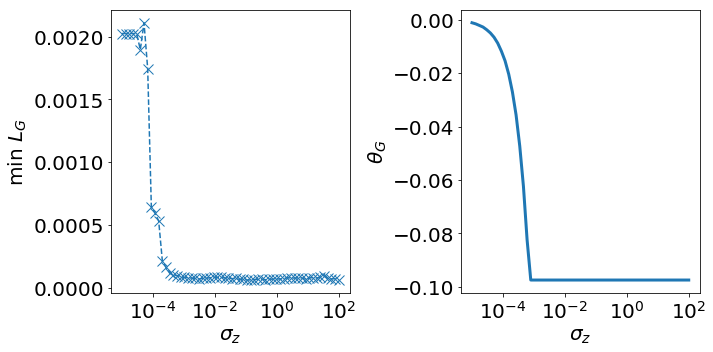

In [321]:
fig = plt.figure(figsize=multiply_figsize(figsize, (2, 1)))
plot_reals = gens
plot_reals = pd.Series(plot_reals).rolling(5).mean().backfill().values
plot_reals = plot_reals[sigmas >= min_sigma]
plot_rmts = min_uGs[sigmas >= min_sigma]

varname= "L_G"
theory_name = "\\theta_G"

plt.subplot(1, 2, 1);
plt.plot(sigmas[sigmas >= min_sigma], plot_reals, 'x--', markersize=10, );
plt.xlabel("$\sigma_z$", fontsize=20);
plt.xscale('log')
xticks = plt.xticks(fontsize=20)
yticks = plt.yticks(fontsize=20)
plt.ylabel("min ${}$".format(varname), fontsize=20);
plt.subplot(1, 2, 2);
plt.plot(sigmas[sigmas >= min_sigma], plot_rmts, linewidth=3);
plt.xlabel("$\sigma_z$", fontsize=20);
plt.xscale('log')
xticks = plt.xticks(fontsize=20)
yticks = plt.yticks(fontsize=20)
plt.ylabel("${}$".format(theory_name), fontsize=20);
plt.tight_layout();

plt.savefig("figures/real_gan_vs_theory_{}.pdf".format(varname))

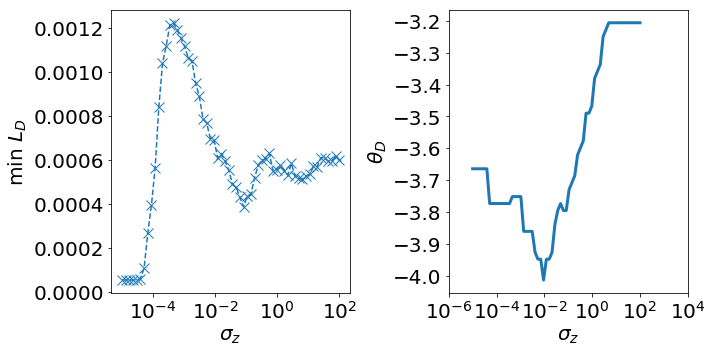

In [324]:
fig = plt.figure(figsize=multiply_figsize(figsize, (2, 1)))
plot_reals = discrims
plot_reals = pd.Series(plot_reals).rolling(5).mean().backfill().values
plot_reals = plot_reals[sigmas >= min_sigma]
plot_rmts = min_uDs[sigmas >= min_sigma]

varname= "L_D"
theory_name = "\\theta_D"

plt.subplot(1, 2, 1);
plt.plot(sigmas[sigmas >= min_sigma], plot_reals, 'x--', markersize=10, );
plt.xlabel("$\sigma_z$", fontsize=20);
plt.xscale('log')
xticks = plt.xticks(fontsize=20)
yticks = plt.yticks(fontsize=20)
plt.ylabel("min ${}$".format(varname), fontsize=20);
plt.subplot(1, 2, 2);
plt.plot(sigmas[sigmas >= min_sigma], plot_rmts, linewidth=3);
plt.xlabel("$\sigma_z$", fontsize=20);
plt.xscale('log')
xticks = plt.xticks(fontsize=20)
plt.xticks(xticks[0][1::2])
yticks = plt.yticks(fontsize=20)
plt.ylabel("${}$".format(theory_name), fontsize=20);
plt.tight_layout();

plt.savefig("figures/real_gan_vs_theory_{}.pdf".format(varname))

In [65]:
possible_sigmas = sigmas[~np.isnan(min_sums)]

In [66]:
min_theoretical_sigma = possible_sigmas[0]

In [67]:
def get_loss(ind=None, sigma=None):
    if ind is not None:
        sigma = sorted(list(results.keys()))[ind]
    discrims = pd.DataFrame(np.array([r[0] for r in results[sigma]]).T).values
    gens = pd.DataFrame(np.array([r[1] for r in results[sigma]]).T).values
    return discrims.T, gens.T

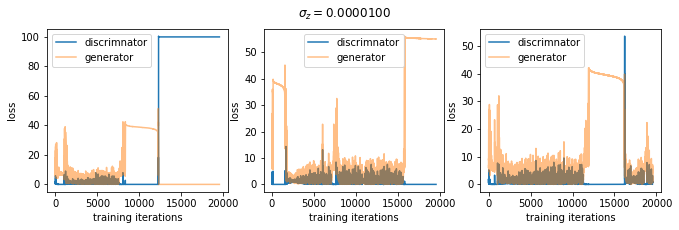

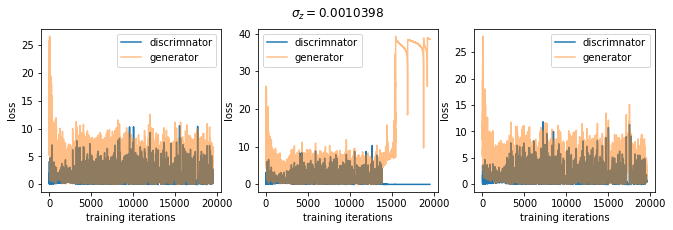

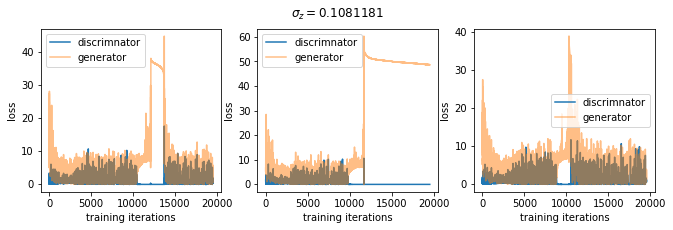

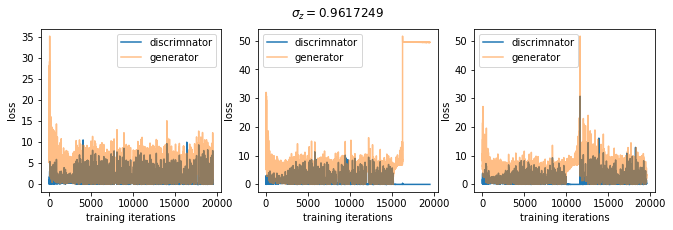

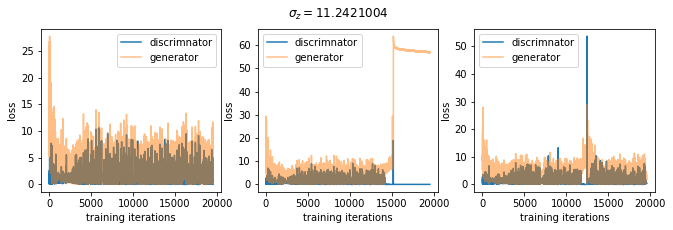

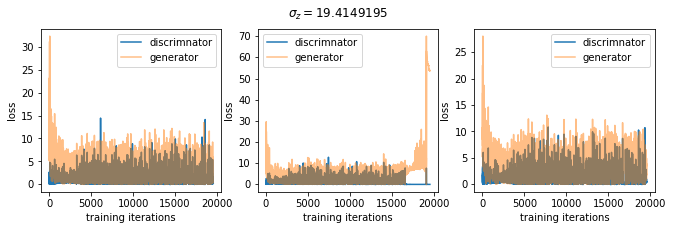

In [150]:
plot_sigmas = [1e-5, 1e-3, 1e-1, 1, 1e1, 2e1]
for plot_sigma in plot_sigmas:
    sigma = possible_sigmas[np.argmin(np.abs(possible_sigmas - plot_sigma))]
    discrim_losses, gen_losses = get_loss(sigma=sigma)
    discrim_failure = max(zip(discrim_losses, gen_losses), key=lambda x: sum((x[0] - x[1])[-700:]))
    gen_failure = max(zip(discrim_losses, gen_losses), key=lambda x: sum((x[1] - x[0])[-200:]))
    success = min(zip(discrim_losses, gen_losses), key=lambda x: np.abs(x[0][-200:]-x[1][-200:]).sum())
    plt.figure(figsize=(11,3))
    for i, traces in enumerate([discrim_failure, gen_failure, success]):
        plt.subplot(1, 3, i+1)
        plt.plot(traces[0], label="discrimnator");
        plt.plot(traces[1], alpha=0.5, label="generator");
        plt.xlabel("training iterations");
        plt.ylabel("loss");
        plt.legend();
    plt.suptitle("$\sigma_z={:.7f}$".format(sigma));

In [325]:
kappas="""0.05000 0.06837 0.08673 0.10510 0.12347 0.14184 0.16020 0.17857 0.19694 0.21531 0.23367 0.25204 0.27041 0.28878 0.30714 0.32551 0.34388 0.36224 0.38061 0.39898 0.41735 0.43571 0.45408 0.47245 0.49082 0.50918 0.52755 0.54592 0.56429 0.58265 0.60102 0.61939 0.63776 0.65612 0.67449 0.69286 0.71122 0.72959 0.74796 0.76633 0.78469 0.80306 0.82143 0.83980 0.85816 0.87653 0.89490 0.91327 0.93163 0.95000"""
kappas = np.array(list((map(float, kappas.split()))))

results_loc = "/work/jr19127/gan-loss-surfaces/rmt_results/vary_kappa"
result_fns = sorted(os.listdir(results_loc), key=lambda s: int(s.split("_")[1]))
rmt_results = []
for fn in result_fns:
    with open(os.path.join(results_loc, fn), "rb") as fin:
        rmt_results.append([x if x is not None else np.nan for x in pkl.load(fin)])
rmt_results = np.array(rmt_results)

# kappas = rmt_results[:, 0]
min_uDs = rmt_results[:, 1]
min_uGs = rmt_results[:, 2]
min_sums = rmt_results[:, 3]
max_diffs = rmt_results[:, 4]

In [326]:
results_dir = "/work/jr19127/gan-loss-surfaces/vary_kappa_dcgan_cifar10"
results_dirs  = [os.path.join(results_dir, "results_{}".format(ind)) 
                 for ind in range(len(os.listdir(results_dir)))][:-1]
pkl_files = [os.path.join(rdir, x) for rdir in results_dirs for x in os.listdir(rdir) if x[-3:]==".pk"]

results = defaultdict(list)
for fn in pkl_files:
    with open(os.path.join(results_dir, fn), "rb") as fin:
        results[float(fn.split("/")[-1][:-3])].append(np.array(pkl.load(fin)))

In [327]:
def summary(arr):
#     return np.min(pd.Series(arr).rolling(100).mean().dropna().values)
#     return arr[-int(len(arr)*0.05):].mean()
    return min(arr)
#     return arr[-1]
#     return np.min(pd.Series(arr).rolling(500).mean().dropna().values)


discrims =np.array([np.mean([summary(r[0]) for r in results[s]]) for s in kappas])
discrims_std = np.array([np.std([summary(r[0]) for r in results[s]]) for s in kappas])

gens = np.array([np.mean([summary(r[1]) for r in results[s]]) for s in kappas])
gens_std = np.array([np.std([summary(r[1]) for r in results[s]]) for s in kappas])

boths = np.array([np.min([summary(r[0]+r[1]) for r in results[s]]) for s in kappas])
boths_std = np.array([np.std([summary(r[0] + r[1]) for r in results[s]]) for s in kappas])

In [265]:
def diff_summary(arr):
    return np.abs(arr).max()
    return np.abs(arr[-4000:]).mean()

diffs = np.array([np.mean([diff_summary(r[0] - r[1]) for r in results[s]]) for s in sigmas])


In [328]:
min_kappa = kappas[~np.isnan(min_uDs)].min()

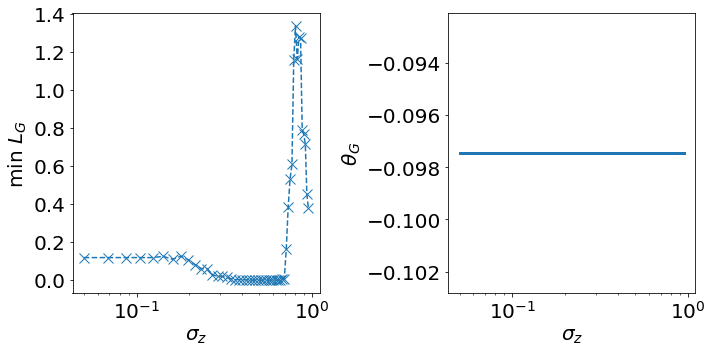

In [330]:
fig = plt.figure(figsize=multiply_figsize(figsize, (2, 1)))
plot_reals = gens
plot_reals = pd.Series(plot_reals).rolling(5).mean().backfill().values
plot_reals = plot_reals[kappas >= min_kappa]
plot_rmts = min_uGs[kappas >= min_kappa]

varname= "L_G"
theory_name = "\\theta_G"

plt.subplot(1, 2, 1);
plt.plot(kappas[kappas >= min_kappa], plot_reals, 'x--', markersize=10, );
plt.xlabel("$\kappa$", fontsize=20);
plt.xscale('log')
xticks = plt.xticks(fontsize=20)
yticks = plt.yticks(fontsize=20)
plt.ylabel("min ${}$".format(varname), fontsize=20);
plt.subplot(1, 2, 2);
plt.plot(kappas[kappas >= min_kappa], plot_rmts, linewidth=3);
plt.xlabel("$\kappa$", fontsize=20);
plt.xscale('log')
xticks = plt.xticks(fontsize=20)
yticks = plt.yticks(fontsize=20)
plt.ylabel("${}$".format(theory_name), fontsize=20);
plt.tight_layout();

plt.savefig("figures/real_gan_vs_theory_{}.pdf".format(varname))

In [ ]:
fig = plt.figure(figsize=multiply_figsize(figsize, (2, 1)))
plot_reals = discrims
plot_reals = pd.Series(plot_reals).rolling(5).mean().backfill().values
plot_reals = plot_reals[kappas >= min_kappa]
plot_rmts = min_uDs[kappas >= min_kappa]

varname= "L_D"
theory_name = "\\theta_D"

plt.subplot(1, 2, 1);
plt.plot(kappas[kappas >= min_kappa], plot_reals, 'x--', markersize=10, );
plt.xlabel("$\kappa$", fontsize=20);
plt.xscale('log')
xticks = plt.xticks(fontsize=20)
yticks = plt.yticks(fontsize=20)
plt.ylabel("min ${}$".format(varname), fontsize=20);
plt.subplot(1, 2, 2);
plt.plot(kappas[kappas >= min_kappa], plot_rmts, linewidth=3);
plt.xlabel("$\kappa$", fontsize=20);
plt.xscale('log')
xticks = plt.xticks(fontsize=20)
yticks = plt.yticks(fontsize=20)
plt.ylabel("${}$".format(theory_name), fontsize=20);
plt.tight_layout();

plt.savefig("figures/real_gan_vs_theory_{}.pdf".format(varname))